# Position Tracking Comparison
This notebook allows interactive analysis of the data collected by the Turtlebot and Webcam.
## Project Setup
### Importing Libraries

In [2]:
%matplotlib notebook

In [3]:
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets


### Importing Data
We define the date and time as variables since they are reused for the two data files. We import the two log files from the Turtlebot and Webcam (collected by the Turtlebot Package `turtlebot3_path_follower` and Chilitag tracker described in `relative.cpp`) into Pandas dataframe representations. The two dataframes are concatanated into a single dataframe `df` in which every data point is indexed by its timestamp and source for easy access & comparison in later analysis.

In [4]:
year = 2020
month = 3
day = 10
robotTime = [16, 59]
webcamTime = [16, 59, 57, 143959]

In [5]:
# Import robot position data
r = pd.read_csv(
    "Turtlebot_position_log-{}-{}-{}-{}:{}.csv".format(year, month, day, *robotTime),
    header=0,
    parse_dates=[0],
    index_col =0,
    infer_datetime_format=True,
)
# sort by timestamp
r = r.sort_values(by="Timestamp")
# remove unnecessary empty column (caused by trailing comma)
r = r.drop(columns="Unnamed: 4")

# Import webcam data
w = pd.read_csv(
    "Webcam_position_log-{}-{:02d}-{:02d}T{}:{}:{}.{}.csv".format(
        year, month, day, *webcamTime
    ),
    header=0,
    parse_dates=[0],
    index_col =0,
    infer_datetime_format=True,
)
# rename theta column so it matches robot data
w = w.rename(columns={"theta(rad)": "Theta(rad)"})
w = w.sort_values(by="Timestamp")
w = w.drop(columns="Unnamed: 5")
# select just tag 42, and discard the tag ID column from here onwards
w = w[w["TagID"] == 42].drop(columns="TagID")

df = pd.concat(
    [w, r], keys=["webcam", "robot"], names=["Data Source", "Timestamp"],
)
df = df.sort_values(by="Timestamp")
df

x(m)      y(m)  Theta(rad)
Data Source Timestamp                                                       
robot       2020-03-10 16:59:29.357132+00:00  0.032879 -0.000032   -0.001227
            2020-03-10 16:59:29.368927+00:00  0.032879 -0.000032   -0.001175
            2020-03-10 16:59:29.384136+00:00  0.032879 -0.000032   -0.001248
            2020-03-10 16:59:29.429560+00:00  0.032879 -0.000032   -0.001107
            2020-03-10 16:59:29.489113+00:00  0.032879 -0.000032   -0.001224
...                                                ...       ...         ...
            2020-03-10 17:04:49.430359+00:00 -0.528596 -0.198695    0.409724
            2020-03-10 17:04:49.476599+00:00 -0.528596 -0.198695    0.409707
            2020-03-10 17:04:49.527956+00:00 -0.528596 -0.198695    0.409732
            2020-03-10 17:04:49.582799+00:00 -0.528596 -0.198695    0.409714
            2020-03-10 17:04:49.625220+00:00 -0.528596 -0.198695    0.409757

[14521 rows x 3 columns]

## Visualising the Data
### Plotting the two paths
We can see here that there is a rotation & translation of the measured robot positions - but what is it? The later functions will explore this.

<IPython.core.display.Javascript object>


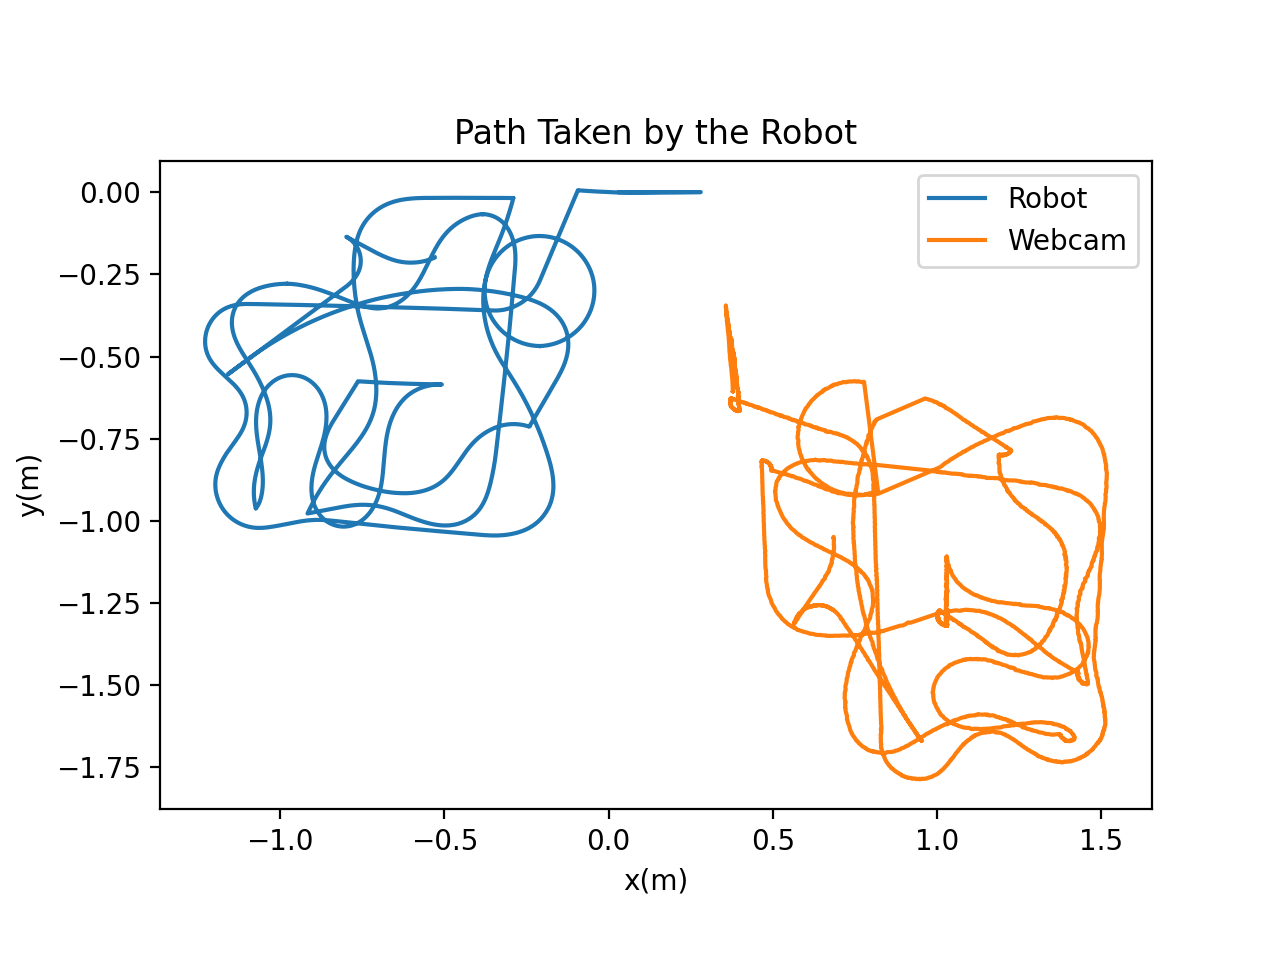

In [6]:
fig1, ax1 = plt.subplots()

ax1.plot(df.loc[("robot","x(m)")], df.loc[("robot","y(m)")],label="Robot",color="tab:blue")
ax1.plot(df.loc[("webcam","x(m)")], df.loc[("webcam","y(m)")],label="Webcam",color="tab:orange")
ax1.legend()
ax1.set_title("Path Taken by the Robot")
ax1.set_xlabel("x(m)")
ax1.set_ylabel("y(m)")
ax1.set_aspect('equal','box')
plt.show()

### Animating Robot Positions

In this section, the measured positions and orientations of the robot during the testing process can be viewed using interactive animations. We can see from this that the webcam-measured positions of the robot sporadically reverses the direction of theta in this dataset (most likely from an anomaly in the `relative.cpp` calculation implementation). 


(To view the animation, the Notebook must be viewed in a running Jupyter Notebook configuration locally or for example on Microsoft Azure Notebooks, static viewers will not render the interactive widgets) 

In [7]:
def arrow_returner(angle, length=0.1):
    dx = length * np.cos(angle)
    dy = length * np.sin(angle)
    return dx, dy

def latest_position_at_millisecond(t):
    if t < 0:
        raise KeyError("Cannot get negative time from start of range.")
    # Relative to first timestamp, t*1e6[ns] = t [ms]
    time = df.index[0][1] + pd.Timedelta(t*1e6)
    if time > df.index[-1][1]:
        raise KeyError("Requested time outside data range.")
    
    # Look for the timestamp (index) at "time", if not use last value ->"pad"
    r_i = df.loc["robot"].index.get_loc(time,method="pad")
    w_i = df.loc["webcam"].index.get_loc(time,method="pad")
    
    # Return the latest data points 
    return df.loc["robot"].iloc[r_i], df.loc["webcam"].iloc[w_i]



# If the `notebook` graphs are flickering, use a different matplotlib backend for faster rendering: 
# 
# %matplotlib inline


def plot_pos_at_time(t_s):
    r_d, w_d = 0,0
    fig2 =plt.figure(figsize=(5, 5), dpi= 100, facecolor='w', edgecolor='k')
    ax2 = fig2.add_subplot()
    ax2.set_title("Path Taken by the Robot")
    ax2.set_xlabel("x(m)")
    ax2.set_xlim(-2,2)
    ax2.set_ylim(-2,2)
    ax2.set_ylabel("y(m)")
    ax2.set_aspect('equal','box')
    
    ax2.plot(
        df.loc[("robot", "x(m)")],
        df.loc[("robot", "y(m)")],
        label="Robot",
        color="tab:blue",
    )
    
    ax2.plot(
        df.loc[("webcam", "x(m)")],
        df.loc[("webcam", "y(m)")],
        label="Webcam",
        color="tab:orange",
    )
    
    try:
        r_d, w_d = latest_position_at_millisecond(t_s*1e3)
        ax2.arrow(r_d["x(m)"],r_d["y(m)"],*arrow_returner(r_d["Theta(rad)"]),width=0.05,color="tab:blue")
        ax2.arrow(w_d["x(m)"],w_d["y(m)"],*arrow_returner(w_d["Theta(rad)"]),width=0.05,color="tab:orange")       
    except KeyError:
        raise
#         display("failed")
        pass     
    plt.show()
    

# t_slider = widgets.IntSlider(min=30,max=300,step=1)
t_input = widgets.IntText(
    value=30,
    description='Specific Time',
    disabled=False
)
# widgets.jslink((t_input, 'value'), (t_slider, 'value'))


widgets.interactive(plot_pos_at_time,t_s=t_input)


interactive(children=(IntText(value=30, description='Specific Time'), Output()), _dom_classes=('widget-interac…

In [8]:
play = widgets.Play(
    interval=200,
    value=50,
    min=30,
    max=300,
    step=1,
    description="Press play",
    disabled=False
)
widgets.jslink((play, 'value'), (t_input, 'value'))
widgets.HBox([play, t_input])

## Calculation of Offset

As mentioned previously, the webcam-measured Theta data is unreliable, however if we plot specific time intervals such as from 54 seconds to 68 seconds, we can see that the two position trackers had a constant offset in Theta, allowing us to calculate the rotation between the datasets.

<IPython.core.display.Javascript object>


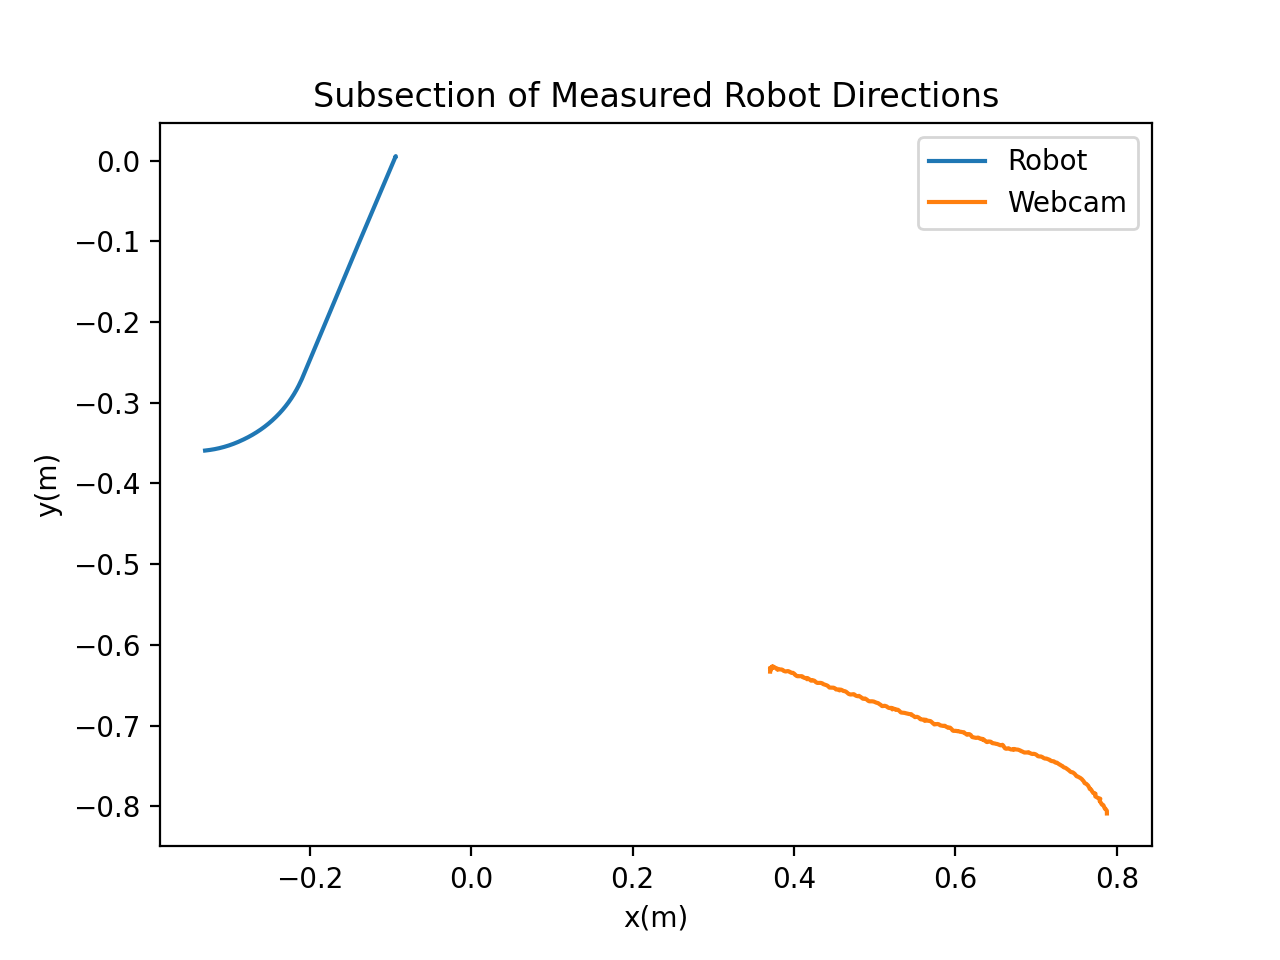

<IPython.core.display.Javascript object>


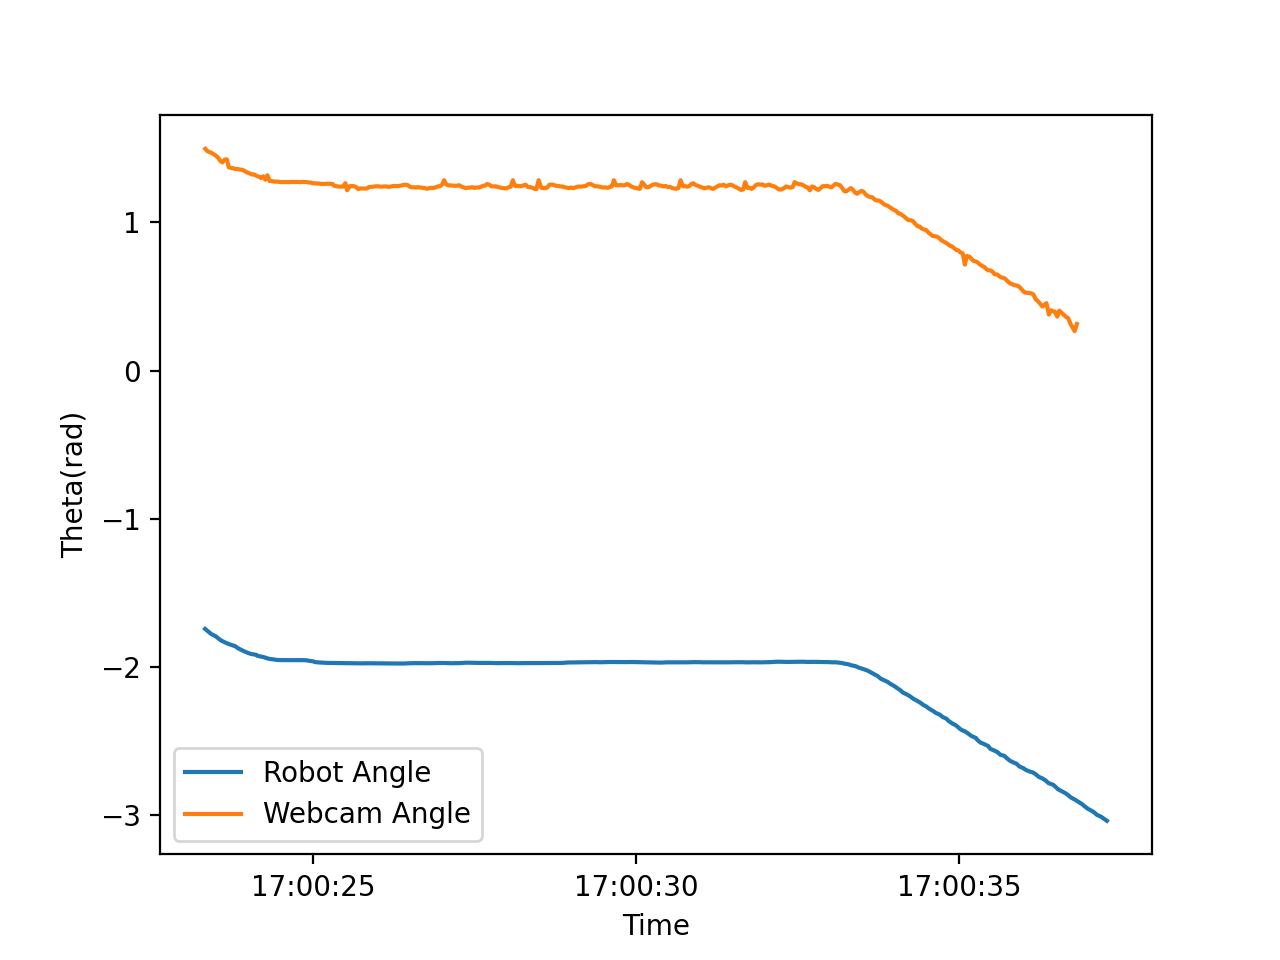

In [25]:
def return_between_milliseconds(t1, t2):
    """A function to return a data slice between two times measured from the start of test."""
    if t1 > t2:
        raise KeyError("Cannot get negative time slice.")
    # Relative to first timestamp, t*1e6[ns] = t [ms]
    time1 = df.index[0][1] + pd.Timedelta(t1 * 1e6)
    time2 = df.index[0][1] + pd.Timedelta(t2 * 1e6)
    if time1 > df.index[-1][1] or time2 > df.index[-1][1]:
        raise KeyError("Requested time outside data range.")

    # Look for the timestamp (index) at "time", if not use last value ->"pad"
    r_i1 = df.loc["robot"].index.get_loc(time1, method="pad")
    w_i1 = df.loc["webcam"].index.get_loc(time1, method="pad")

    r_i2 = df.loc["robot"].index.get_loc(time2, method="pad")
    w_i2 = df.loc["webcam"].index.get_loc(time2, method="pad")

    # Return the latest data points
    return df.loc["robot"].iloc[r_i1:r_i2], df.loc["webcam"].iloc[w_i1:w_i2]


def plot_between_seconds(t1,t2):
    r_t_slice, w_t_slice = return_between_milliseconds(t1*1e3, t2*1e3)
    # print(r_t_slice["x(m)"])
    # print(w_t_slice)
    fig3, ax3 = plt.subplots()
    ax3.plot(r_t_slice["x(m)"], r_t_slice["y(m)"],label="Robot",color="tab:blue")
    ax3.plot(w_t_slice["x(m)"], w_t_slice["y(m)"],label="Webcam",color="tab:orange")
    ax3.legend()
    ax3.set_title("Subsection of Path Taken by the Robot")
    ax3.set_xlabel("x(m)")
    ax3.set_ylabel("y(m)")
    ax3.set_aspect('equal','box')

    fig4, ax4 = plt.subplots()
    ax4.plot(r_t_slice.index, r_t_slice["Theta(rad)"],label="Robot Angle",color="tab:blue")
    ax4.plot(w_t_slice.index, w_t_slice["Theta(rad)"],label="Webcam Angle",color="tab:orange")
    ax4.legend()
    ax3.set_title("Subsection of Measured Robot Directions")
    ax4.set_xlabel("Time")
    ax4.set_ylabel("Theta(rad)")
    
    
    plt.show()
    
 

    
t_1 = widgets.IntText(
    value=54,
    description='t1',
    disabled=False
)
t_2 = widgets.IntText(
    value=68,
    description='t2',
    disabled=False
)

# Un-comment the line below to interact with the subset of the data plotted
# widgets.interactive(plot_between_seconds,t1=t_1,t2=t_2)
plot_between_seconds(54,68)

To compare these two datasets, we need to decide on the sample times and frames of reference we wish to use. 

Here, I have chosen to use the timestamps from the robot dataset, and gathered the webcam measurement that was taken closest in _time_ to the robot position measurement. This was chosen because the webcam measurements are to be used to calibrate the robot measurements, thus we care most about preserving the sampling time of the robot positions as such a calibration would allow us to rely on robot-produced measurements in the future. 

The position data collected from the robot has an _x_ and _y_ axis that is unreferenced to the environment, thus the robot data will be rotated and translated onto the webcam frame of reference, as that is fixed to the environment (as it is relative to the Chilitag positions).

<IPython.core.display.Javascript object>


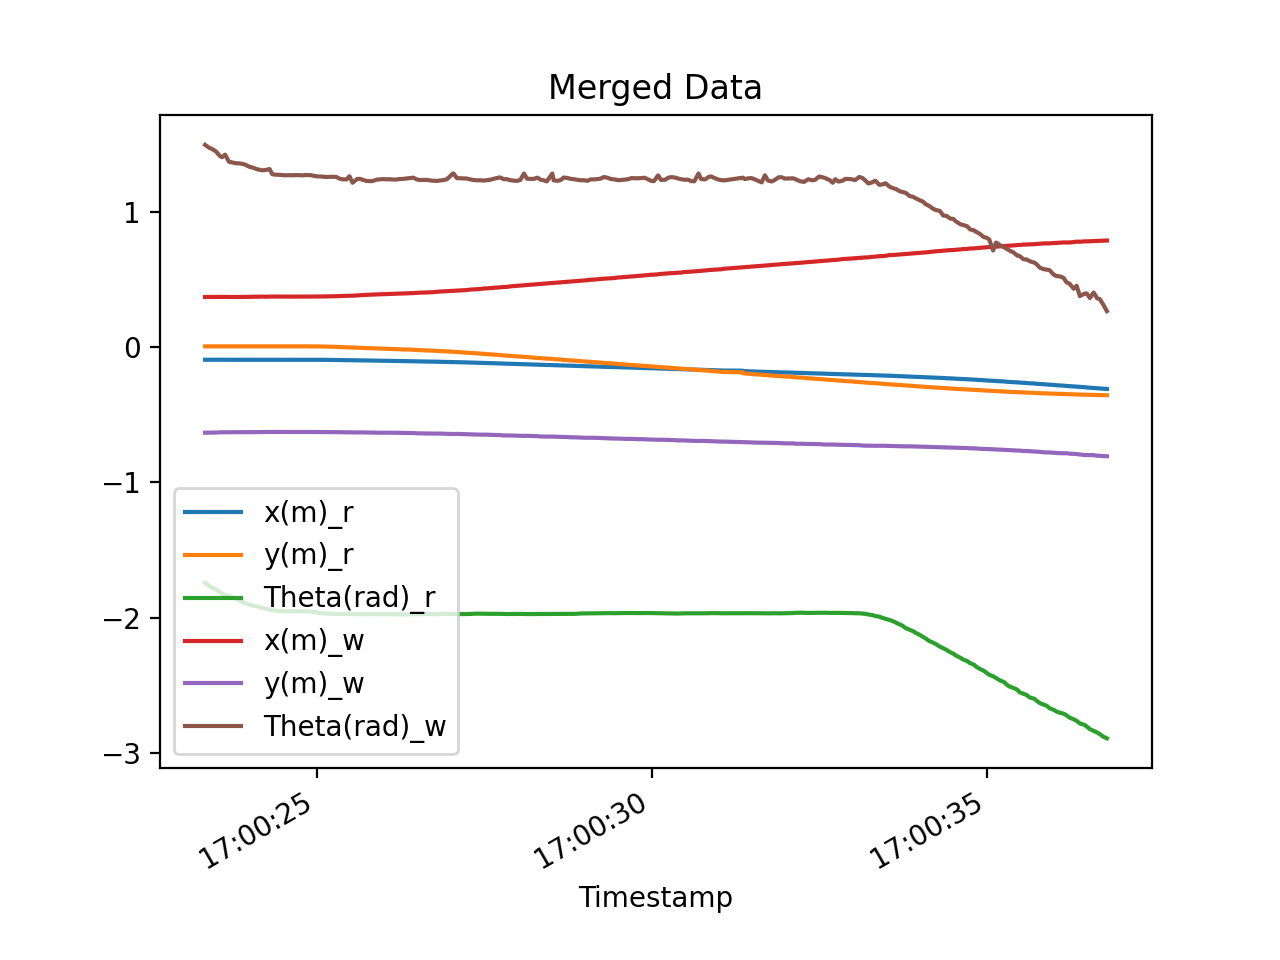

<IPython.core.display.Javascript object>


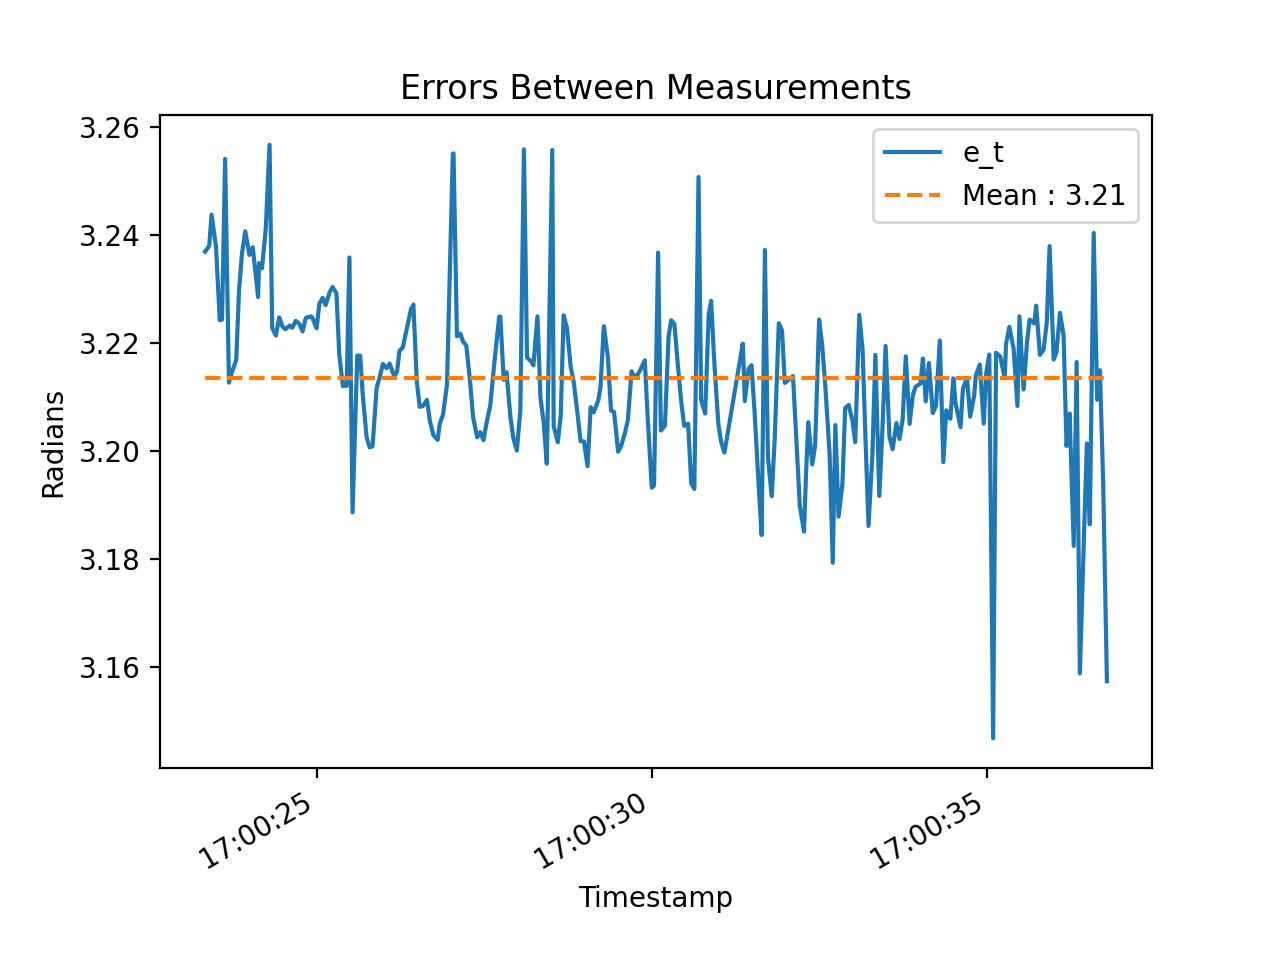

In [10]:
r_t_slice, w_t_slice = return_between_milliseconds(54*1e3, 67.5*1e3)

   
# Merge the two slices, recording the webcam measurement closest in time to each robot measurement.
m = pd.merge_asof(r_t_slice, w_t_slice, left_index=True, right_index=True,direction="nearest",suffixes=["_r","_w"])
m.plot()
plt.title("Merged Data")
# m["e_x"] = m["x(m)_w"] - m["x(m)_r"]
# m["e_y"] = m["y(m)_w"] - m["y(m)_r"]
m["e_t"] = m["Theta(rad)_w"] - m["Theta(rad)_r"] 
m.plot(y="e_t")
plt.title("Errors Between Measurements")
plt.ylabel("Radians")

mean = np.mean(m["e_t"])
plt.plot( m["e_t"].index, mean * np.ones(m["e_t"].shape), "--", label="Mean : {:.2f}".format(mean))
plt.legend()
plt.show()


We can use the mean value of theta calculated here to rotate the robot data to the webcam axes. One anomaly not previously mentioned is that the webcam-reported direction of the robot has a constant +90 degree offset from the true direction of the robot (this is visible from the animated path above). We correct for this by rotating the dataset by `mean-np.pi/2`.

<IPython.core.display.Javascript object>


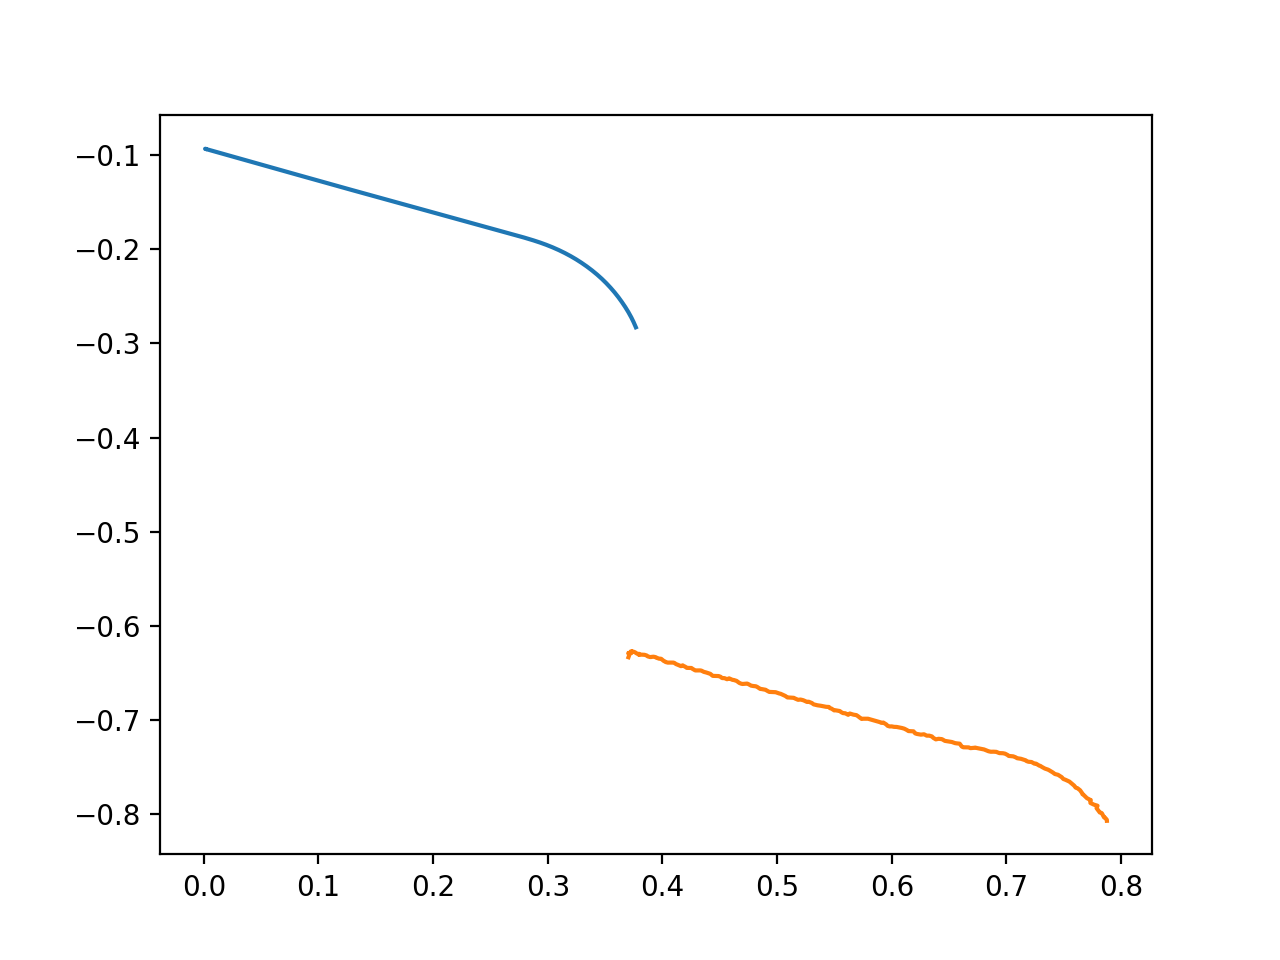

In [26]:
points = m[["x(m)_r","y(m)_r"]]

def rotate_frame(points, theta):
    """Rotate vector of points by Theta"""
    if points.shape[1] !=2:
        return ValueError("Need to supply a n x 2 matrix of points")
    r = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return np.matmul(r,points.T).T

rotated_robot_path = rotate_frame(points,mean-np.pi/2) # Including webcam offset
webcam_path = np.array([m["x(m)_w"].to_numpy(), m["y(m)_w"].to_numpy()])

plt.figure()
plt.plot(rotated_robot_path["x(m)_r"],rotated_robot_path["y(m)_r"])
plt.plot(m["x(m)_w"],m["y(m)_w"])


Next we can see the effect of this rotation on the whole dataset, using a manually chosen translation of (+0.42, -0.56) to attempt to align the two plots.

                                      x(m)      y(m)
Timestamp                                           
2020-03-10 16:59:29.357132+00:00  0.032879 -0.000032
2020-03-10 16:59:29.368927+00:00  0.032879 -0.000032
2020-03-10 16:59:29.384136+00:00  0.032879 -0.000032
2020-03-10 16:59:29.429560+00:00  0.032879 -0.000032
2020-03-10 16:59:29.489113+00:00  0.032879 -0.000032
...                                    ...       ...
2020-03-10 17:04:49.430359+00:00 -0.528596 -0.198695
2020-03-10 17:04:49.476599+00:00 -0.528596 -0.198695
2020-03-10 17:04:49.527956+00:00 -0.528596 -0.198695
2020-03-10 17:04:49.582799+00:00 -0.528596 -0.198695
2020-03-10 17:04:49.625220+00:00 -0.528596 -0.198695

[6408 rows x 2 columns]


<IPython.core.display.Javascript object>


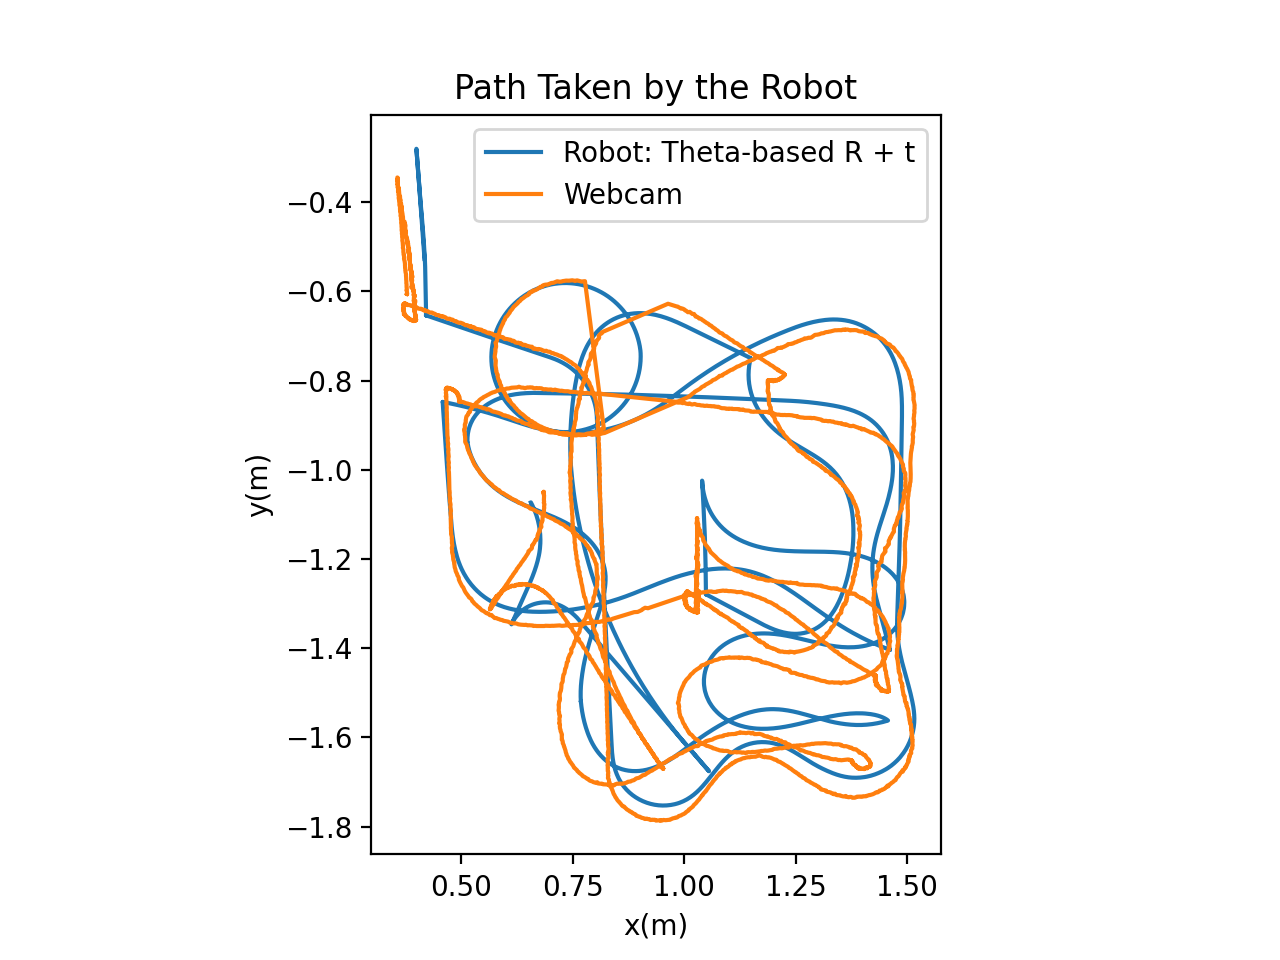

In [28]:
# df.index
print(df.loc[("robot",["x(m)","y(m)"])])


# rotated_robot_path = rotate_frame(df.loc["robot"][["x(m)","y(m)"]],mean-np.pi/2)
rf = rotate_frame(df.loc[("robot",["x(m)","y(m)"])],mean-np.pi/2)
rf["x(m)"]= rf["x(m)"] +0.42
rf["y(m)"]= rf["y(m)"] -0.56
# n = pd.merge_asof(rf, df.loc[("webcam")], left_index=True, right_index=True,direction="nearest",suffixes=["_r","_w"])
# n["e_x"] = 
fig6, ax6 = plt.subplots()
ax6.plot(rf["x(m)"], rf["y(m)"],label="Robot: Theta-based R + t",color="tab:blue")
# ax6.plot(df.loc[("robot","x(m)")], df.loc[("robot","y(m)")],label="Robot",color="tab:blue")
ax6.plot(df.loc[("webcam","x(m)")], df.loc[("webcam","y(m)")],label="Webcam",color="tab:orange")

ax6.legend()
ax6.set_title("Path Taken by the Robot")
ax6.set_xlabel("x(m)")
ax6.set_ylabel("y(m)")
ax6.set_aspect('equal','box')
plt.show()

### Least-Squares Approach
Alternatively, a more rigorous approach is to use all of the data points to calculate the optimal rotation and translation to minimise the errors between the datasets. Below, an implementation following [this note on using the SVD](https://igl.ethz.ch/projects/ARAP/svd_rot.pdf) is employed to calculate the optimal rotation and translation.

This approach benefits from ignoring the noisy measurement of Theta from the webcam, instead calculating the rotation from the (_x_,_y_) correspondences.

R: [[-0.03290771 -0.99945839]
 [ 0.99945839 -0.03290771]]
t: [ 0.42107707 -0.56934887]


<IPython.core.display.Javascript object>


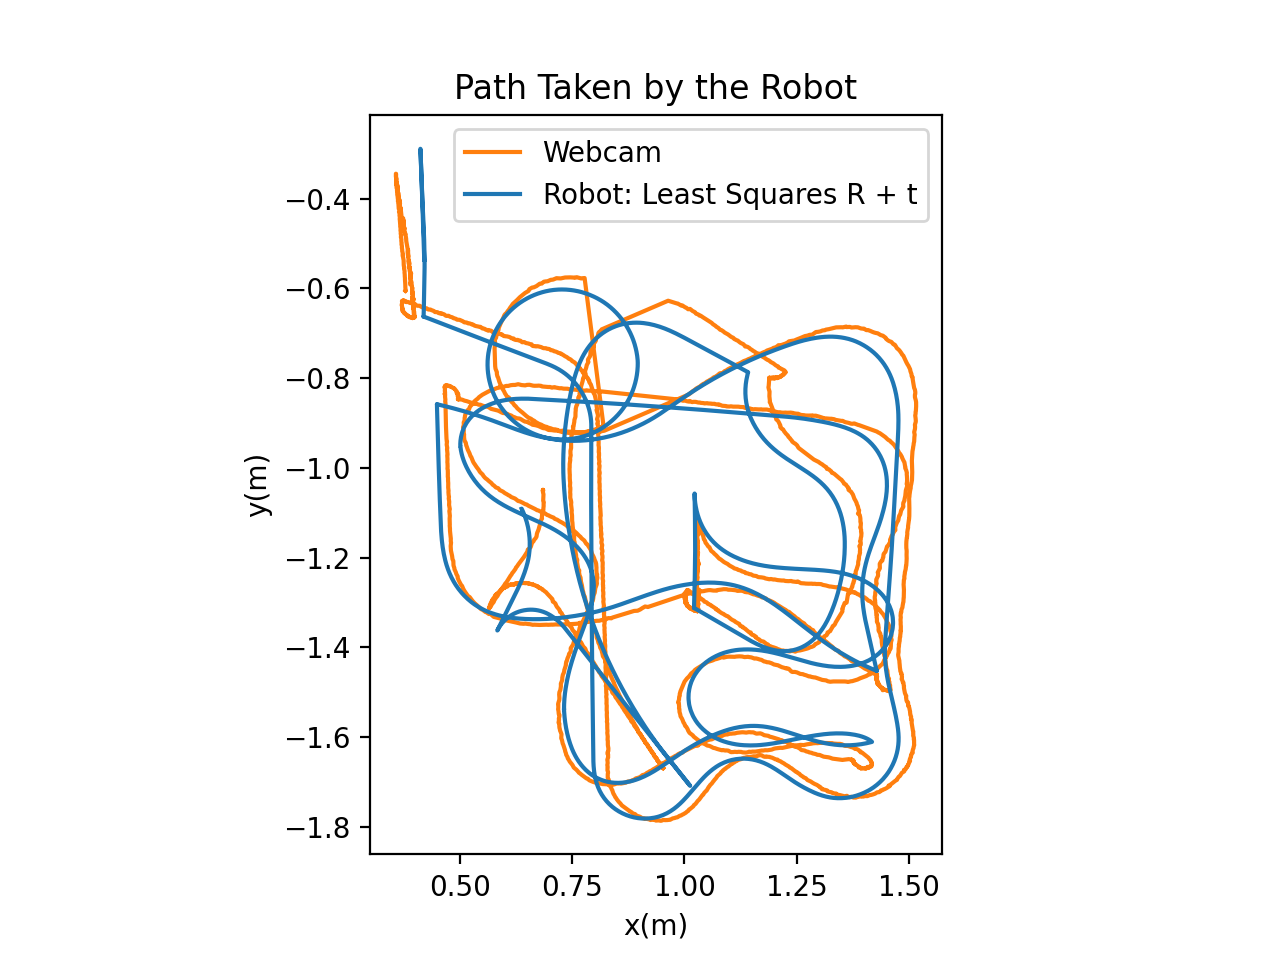

In [27]:
mf = pd.merge_asof(df.loc[("robot")], df.loc[("webcam")], left_index=True, right_index=True,direction="nearest",suffixes=["_r","_w"])

# Least Squares Matching

q_i = mf[["x(m)_w","y(m)_w"]].to_numpy()
p_i = mf[["x(m)_r","y(m)_r"]].to_numpy()

# Convert to zero-centred
x_i = p_i - np.mean(p_i,axis=0)
y_i = q_i - np.mean(q_i,axis=0)

# Calculate least-squares matrices
S = np.matmul(x_i.T, y_i)
u,s,vh = np.linalg.svd(S)
vu_det = np.linalg.det(np.matmul(vh.T, u.T))
diag = np.array([[1,0],[0,vu_det]])

# Use these to calculate rotation and translation
R = np.matmul(vh.T,np.matmul(diag,u.T))
t = np.mean(q_i,axis=0) - np.matmul(R,np.mean(p_i,axis=0))

print("R:", R)
print("t:",t)

# Rotate & Translate the robot data accordingly
out = np.matmul(R,p_i.T) 

out[0,:] = out[0,:] + t[0]
out[1,:] = out[1,:] + t[1]

# Plot webcam and altered robot data on a graph
fig7, ax7 = plt.subplots()

ax7.plot(q_i[:,0],q_i[:,1],label="Webcam",color="tab:orange")
# plt.plot(p_i[:,0],p_i[:,1],label="Unaltered Robot")
ax7.plot(out.T[:,0],out.T[:,1],label="Robot: Least Squares R + t",color="tab:blue")
ax7.legend()
ax7.set_title("Path Taken by the Robot")
ax7.set_xlabel("x(m)")
ax7.set_ylabel("y(m)")
ax7.set_aspect('equal','box')

We can see from either of the above two figures that the datasets do not align. This is to be expected, as the robot-produced data is likely to drift due to error integration in encoders etc. and the aim of this experiment is to calibrate for that, however since the camera has not been calibrated itself there is a concern that the difference between the two datasets is influenced by camera distortion. For a 2D projective camera calibration (i.e. to form a _homography_) we require at least 4 known points on the plane to calibrate the camera. This could be achieved if each corner of the Chilitags were reported in the log files, however the decision was made earlier to calibrate within `relative.cpp`. The calibration that was performed within `relative.cpp` to collect this data does not fulfil the definition for full calibration. For a fully-reliable webcam dataset we would also wish to accomodate for lens distortion.